In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# For sklearn 0.18
# import sklearn.model_selection as skcv

import sklearn.cross_validation as skcv
import sklearn.ensemble as sk

## Вопросы
* Как работает roc_auc, где у классификатора переменный порог?
* ~~Как работает кросс-валидация, можно ли (нужно ли?) получить обученный классификатор?~~ По идее, учить сразу на всех тестовых данных лучше всего, кросс-валидировать можно и отдельно.

## Данные

In [3]:
gold = pd.read_csv('cont_01/gold.csv')
gold.head(20)

,mid,times,player_0,player_1,player_2,player_3,player_4,player_5,player_6,player_7,player_8,player_9
0,0,60,750,350,389,437,428,398,344,654,287,1056
1,0,120,957,1071,633,655,1080,669,1147,1164,438,1360
2,0,180,1161,1527,782,1103,1346,1058,1479,1574,587,2072
3,0,240,1571,2033,932,1515,2058,1760,1767,2387,737,2283
4,0,300,1721,2313,1082,1790,2699,2087,1986,2898,887,3302
5,0,360,1871,2753,1232,2126,3645,2417,2382,3416,1037,4071
6,0,420,2022,3216,1382,2703,4176,2567,2778,4115,1187,4686
7,0,480,2850,3941,2129,3249,5040,2717,3326,4931,1424,5207
8,0,540,3303,4686,2402,3716,5546,3428,3596,5580,1574,5609
9,0,600,3454,5206,2613,4426,5755,4072,3997,5917,1725,6384


In [4]:
train = pd.read_csv('cont_01/train.csv')
train.head(10)

,mid,radiant_won
0,0,1
1,1,0
2,2,1
3,4,1
4,5,1
5,6,1
6,8,0
7,11,0
8,20,1
9,26,1


In [5]:
lh = pd.read_csv('cont_01/lh.csv')
lh.head(10)

,mid,times,player_0,player_1,player_2,player_3,player_4,player_5,player_6,player_7,player_8,player_9
0,0,60,1,2,1,1,2,3,2,7,1,2
1,0,120,1,5,1,2,6,5,6,14,1,6
2,0,180,2,10,1,7,8,9,9,18,1,9
3,0,240,2,13,1,13,12,9,12,29,1,10
4,0,300,2,15,1,17,19,13,13,36,1,19
5,0,360,2,20,1,20,24,16,17,42,1,31
6,0,420,3,26,1,28,30,16,21,52,1,31
7,0,480,4,36,1,36,35,16,28,63,2,36
8,0,540,4,37,2,43,40,25,30,72,2,38
9,0,600,4,43,3,57,41,34,35,75,2,46


In [6]:
events = pd.read_csv('cont_01/events.csv')
events.head(10)

,mid,event_type,from_team,time
0,0,3,radiant,1
1,1,3,radiant,222
2,2,3,dire,143
3,3,3,radiant,143
4,4,3,dire,53
5,6,3,radiant,82
6,6,6,radiant,523
7,7,3,dire,77
8,7,6,radiant,283
9,7,6,radiant,595


## Обработка

In [7]:
team0 = ['player_%s'%t for t in range(0,5)]
team1 = ['player_%s'%t for t in range(5,10)]
print(team0,team1)

['player_0', 'player_1', 'player_2', 'player_3', 'player_4'] ['player_5', 'player_6', 'player_7', 'player_8', 'player_9']


In [8]:
gold['gold_team0'] = gold[team0].sum(axis=1)
gold['gold_team1'] = gold[team1].sum(axis=1)
gold_end = gold[gold.times==600].drop('times',axis=1)
gold_end['ratio'] = gold_end.gold_team0 / gold.gold_team1

In [9]:
%matplotlib inline

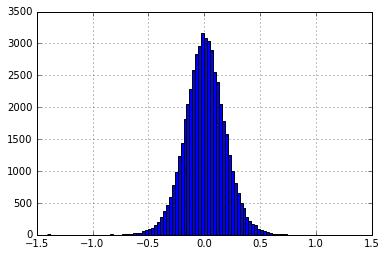

In [11]:
# gold_end.ratio.hist(bins=100)
# Use log to balance cases like (0.3 vs 3)
np.log(gold_end['ratio']).hist(bins=100)

## Обучение на двух параметрах

In [16]:
data = pd.merge(train,gold_end,on='mid',how='left')
X = data.drop(['mid', 'radiant_won'], axis=1).drop(team0 + team1 + ["gold_team1"], axis=1)
Y = data['radiant_won']
X.head()

,gold_team0,ratio
0,21454,0.970989
1,22165,0.903366
2,21392,1.375868
3,18038,1.031686
4,16017,0.726691


In [69]:
clf = sk.RandomForestClassifier(n_estimators=100, max_depth=1)
clf.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

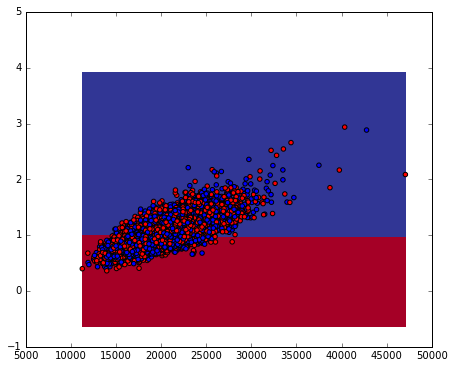

In [78]:
def get_meshgrid(X, f1, f2, npoints=100, border=1):
    step1 = (X[f1].max() - X[f1].min()) / npoints
    step2 = (X[f2].max() - X[f2].min()) / npoints
    x1_min, x1_max = X[f1].min() - border, X[f1].max() + border
    x2_min, x2_max = X[f2].min() - border, X[f2].max() + border
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, step1), np.arange(x2_min, x2_max, step2))
    return xx1,xx2

def vis_mesh(clf, X, Y, f1,f2):
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    xx1,xx2 = get_meshgrid(X, f1,f2)
    xgr = np.c_[xx1.ravel(), xx2.ravel()]
    y = clf.predict(xgr).reshape(xx1.shape)
    plt.pcolormesh(xx1,xx2,y, cmap=plt.cm.RdYlBu)
    c = ['r' if y==0 else 'b' for y in Y]
    Xrnd = X.sample(frac=1)
    plt.scatter(Xrnd[f1].iloc[:], Xrnd[f2].iloc[:], c=c, cmap=plt.cm.RdYlBu)

vis_mesh(clf, X, Y, "gold_team0", "ratio")

## Обучение

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


In [ ]:
data = pd.merge(train,gold_end,on='mid',how='left')
X = data.drop(['mid', 'radiant_won'], axis=1) #.drop(team0, axis=1).drop(team1, axis=1)
Y = data['radiant_won']

clf = sk.RandomForestClassifier(n_estimators=100)
clf.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
skcv.cross_val_score(clf, X, Y, cv=5, scoring='roc_auc')

In [100]:
clf.predict(X.iloc[:])

array([1, 0, 1, ..., 1, 0, 0])

http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_iris.html

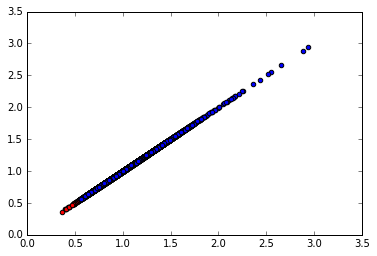

In [119]:
def draw_contour(clf, X, feature1, feature2):
    #plot_step = 100
    #x1_min, x1_max = X[feature1].min() - 1, X[feature1].max() + 1
    #x2_min, x2_max = X[feature2].min() - 1, X[feature2].max() + 1
    #xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, plot_step),
    #                       np.arange(x2_min, x2_max, plot_step))
    y = clf.predict(X)
    idx0 = np.where(y==0)
    idx1 = np.where(y==1)
    #print(f1.iloc[idx0].values)
    plt.scatter(X[feature1].iloc[idx0], X[feature2].iloc[idx0], c='r', cmap=plt.cm.RdYlBu)
    plt.scatter(X[feature1].iloc[idx1], X[feature2].iloc[idx1], c='b', cmap=plt.cm.RdYlBu)
    
draw_contour(clf, X, "ratio", "ratio")
plt.show()
    